#1. Import packages

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import time
import h5py
import sys
import matplotlib.pyplot as plt
from keras.layers import Dense,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
from tqdm import tqdm

#2. Datasets
Facial detection dataset, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces.

Positive training data: CelebA Dataset. A large-scale (over 200K images) of celebrity faces.
Negative training data: ImageNet. Many images across many different categories. We'll take negative examples from a variety of non-human categories. Fitzpatrick Scale skin type classification system, with each image labeled as "Lighter'' or "Darker''.

In [3]:
# class for loading dataset
class TrainingDatasetLoader(object):
    def __init__(self, data_path):

        print ("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, 'r')

        print ("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache['images'][:]
        self.labels = self.cache['labels'][:].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces:
            selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else:
            selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
            selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
            selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds,:,:,::-1]/255.).astype(np.float32)
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return (self.images[most_prob_inds,...]/255.).astype(np.float32)

    def get_all_train_faces(self):
        return self.images[ self.pos_train_inds ]

In [4]:
# Geting the training data: images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')

# TrainingDatasetLoader using the downloaded dataset
data_loader = TrainingDatasetLoader(path_to_training_data)

1263902720/1263889489 [==============================] - 56s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [5]:
number_of_training_examples = data_loader.get_train_size()

#taking only 500 images for examining - ploting it to see what is it dataset actually
(images, labels) = data_loader.get_batch(500)

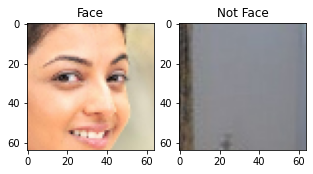

In [6]:
### Examining the CelebA training dataset ###
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 40
idx_not_face = 10

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [7]:
print("shape of face images:", face_images.shape)
print("Shape of no face images:", not_face_images.shape)

shape of face images: (250, 64, 64, 3)
Shape of no face images: (250, 64, 64, 3)


#3. GAN Class

In [8]:
class GAN:
    
    def __init__(self, img_shape, z_dim):
        self.img_shape = img_shape
        self.z_dim = z_dim
        self.losses = []
        self.accuracies = []
        self.iteration_checks = []

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.z_dim))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(64*64*1, activation='tanh'))
        model.add(Reshape(self.img_shape))
        return model

    def build_discriminator(self):
        model=Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def build_gan(self, generator, discriminator):
        discriminator.trainable=False
        model = Sequential()
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model
    
    def compile_gan(self):
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan(self.generator, self.discriminator)
    
    def display_images(self, ):
        z = np.random.normal(0,1 , (16,100))
        generator_images = self.generator.predict(z)
        generator_images = 0.5*generator_images + 0.5
        
        fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
        cnt=0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(generator_images[cnt,:,:,0],cmap='gray')
                axs[i, j].axis('off')
                cnt+=1
        fig.show()
        
    
    def fit(self, X, batch_size=32, interations=10, intervals=1):
        
        #X_train, y_train = X[0], X[1]
        #X_train = X_train/127.5-1.0
        
        X = X/127.5-1.0
        #X = (X_train, y_train)
        
        real_X = np.ones((batch_size, 1))
        fake_X = np.zeros((batch_size, 1))
        
        for iteration in tqdm(range(interations)):
            ids = np.random.randint(0, X.shape[0], batch_size)
            imgs = X[ids]
            
            z = np.random.normal(0, 1, (batch_size, self.z_dim))
            
            generator_images = self.generator.predict(z)
            
            dloss_real = self.discriminator.train_on_batch(imgs, real_X)
            dloss_fake = self.discriminator.train_on_batch(generator_images, fake_X)
            
            dloss, accuracy = dloss,accuracy = 0.5 * np.add(dloss_real,dloss_fake)
            
            
            z = np.random.normal(0, 1, (batch_size, self.z_dim))
            gloss = self.gan.train_on_batch(z, real_X)
            
            if (iteration+1) % intervals == 0:
                self.losses.append((dloss,gloss))
                self.accuracies.append(100.0*accuracy)
                self.iteration_checks.append(iteration+1)

                print("%d [D loss: %f , acc: %.2f] [G loss: %f]" %(iteration+1,dloss,100.0*accuracy,gloss))
                self.display_images()

#4. Modeling the GAN

In [9]:
train_size = 1000
img_rows=64
img_cols=64

channels=1

img_shape = (img_rows, img_cols, channels)

z_dim=100


X_train = data_loader.get_batch(train_size)

images = X_train[0].reshape((-1, 64,64, 1))

In [10]:
model = GAN(img_shape=img_shape, z_dim=z_dim)
model.compile_gan()

 50%|████▉     | 998/2000 [01:30<01:25, 11.78it/s]

1000 [D loss: 1.369298 , acc: 56.25] [G loss: 0.517666]


100%|█████████▉| 1999/2000 [02:57<00:00, 11.88it/s]

2000 [D loss: 0.217419 , acc: 100.00] [G loss: 2.710447]


100%|██████████| 2000/2000 [02:58<00:00, 11.23it/s]


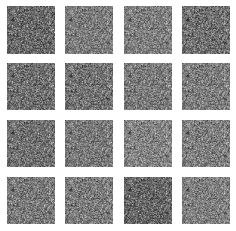

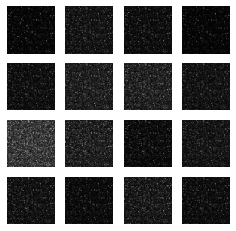

In [11]:
model.fit(images, batch_size=32, interations=2000, intervals=1000)